# Sprint18-19　セグメンテーション

## 細胞核画像を対象に細胞のセグメンテーションを行う
## セグメンテーションに用いるモデル：U-net 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import nucleus

%matplotlib inline 
LOGS_DIR = "./"

/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_DIR = "./"
class NoResizeConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "none"
    
config = NoResizeConfig()

In [3]:
config = nucleus.NucleusInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

In [4]:
DEVICE = "/cpu:0"
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [6]:
# Load validation dataset
dataset = nucleus.NucleusDataset()
dataset.load_nucleus(DATASET_DIR, "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 25
Classes: ['BG', 'nucleus']


In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

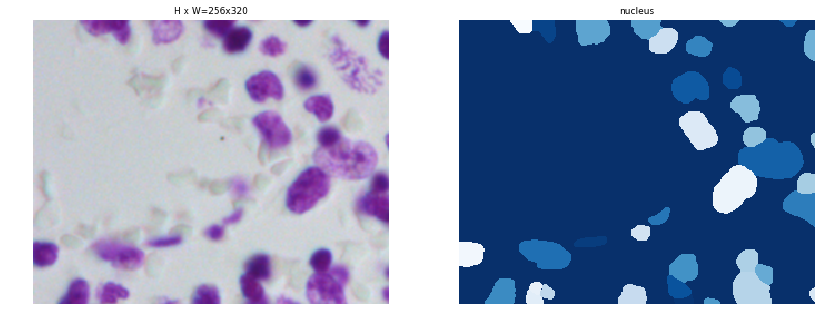

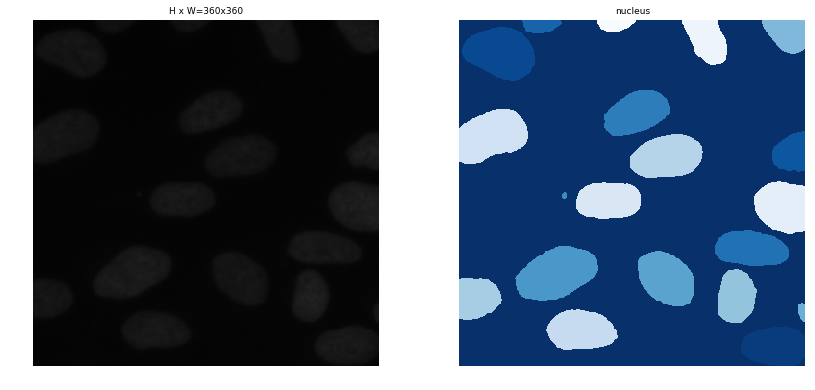

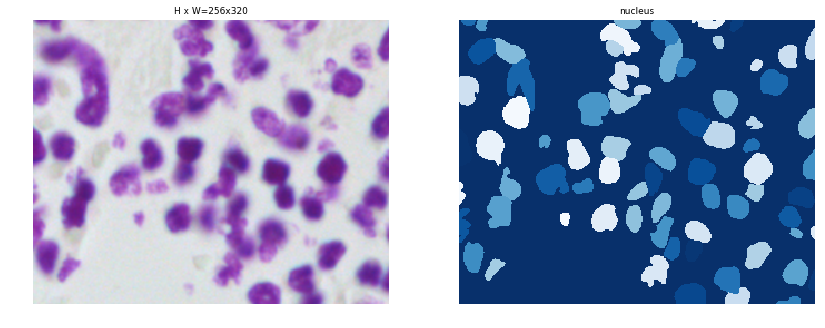

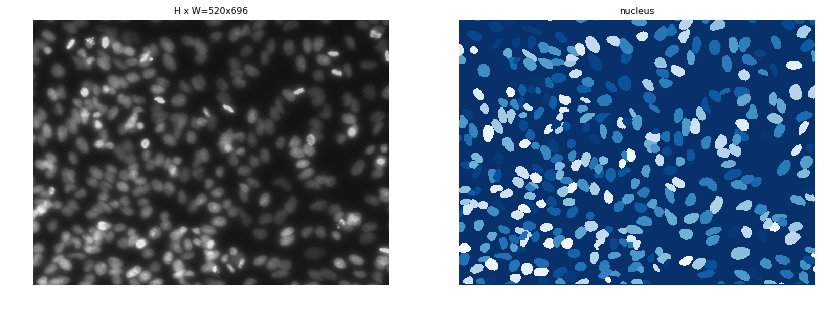

In [9]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

## EDA   

In [22]:
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from cv2 import imread 

In [19]:
imgs = []
masks = []
img_data = []
mask_data = []
TRAIN_PATH = 'input/stage1_train/'
train_ids = next(os.walk(TRAIN_PATH))[1] 
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')
    
    imgs.append(img)
    img_height = img.shape[0]
    img_width = img.shape[1]
    img_area = img_width * img_height

    nucleus_count = 1
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask = imread(path + '/masks/' + mask_file)
        masks.append(mask)
        mask_height = mask.shape[0]
        mask_width = mask.shape[1]
        mask_area = mask_width * img_height
        
        nucleus_area = (np.sum(mask) / 255)
        
        mask_to_img_ratio = nucleus_area / mask_area
        
        mask_data.append([n, mask_height, mask_width, mask_area, nucleus_area, mask_to_img_ratio])
        
        nucleus_count = nucleus_count + 1
  
    img_data.append([img_height, img_width, img_area, nucleus_count])

100%|██████████| 670/670 [01:10<00:00,  9.53it/s]


In [23]:
df_img = pd.DataFrame(img_data, columns=['height', 'width', 'area', 'nuclei'])

In [174]:
df_img.describe()

,height,width,area,nuclei
count,670.000000,670.000000,6.700000e+02,670.000000
mean,333.991045,378.500000,1.547583e+05,44.971642
std,149.474845,204.838693,1.908250e+05,47.962530
min,256.000000,256.000000,6.553600e+04,2.000000
25%,256.000000,256.000000,6.553600e+04,16.250000
50%,256.000000,320.000000,8.192000e+04,28.000000
75%,360.000000,360.000000,1.296000e+05,55.000000
max,1040.000000,1388.000000,1.443520e+06,376.000000


画像は合計６７０枚

In [25]:
df_img.head()

,height,width,area,nuclei
0,256,256,65536,17
1,256,256,65536,33
2,256,320,81920,112
3,256,256,65536,7
4,256,320,81920,38


In [26]:
df_img.tail()

,height,width,area,nuclei
665,256,256,65536,17
666,256,256,65536,22
667,256,320,81920,23
668,256,256,65536,18
669,256,256,65536,38


In [27]:
df_mask = pd.DataFrame(mask_data, columns=['img_index', 'height', 'width', 'area',\
                                           'nucleus_area', 'mask_to_img_ratio'])

In [28]:
df_mask.describe()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
count,29461.000000,29461.000000,29461.000000,2.946100e+04,29461.000000,29461.000000
mean,339.072571,404.408642,506.068090,2.511955e+05,1415.411120,0.009496
std,188.400229,187.400013,282.185678,2.516759e+05,1751.511121,0.013465
min,0.000000,256.000000,256.000000,6.553600e+04,63.000000,0.000060
25%,170.000000,256.000000,256.000000,6.553600e+04,354.000000,0.002976
50%,344.000000,360.000000,360.000000,1.296000e+05,915.000000,0.005173
75%,498.000000,520.000000,696.000000,3.619200e+05,1722.000000,0.010129
max,669.000000,1040.000000,1388.000000,1.443520e+06,33111.000000,0.250671


マスク画像（核１つにつき１枚）は合計29461枚

In [29]:
df_mask.head()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
0,0,256,256,65536,1971.0,0.030075
1,0,256,256,65536,741.0,0.011307
2,0,256,256,65536,1935.0,0.029526
3,0,256,256,65536,1329.0,0.020279
4,0,256,256,65536,1131.0,0.017258


In [30]:
df_mask.tail()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
29456,669,256,256,65536,639.0,0.009750
29457,669,256,256,65536,891.0,0.013596
29458,669,256,256,65536,1086.0,0.016571
29459,669,256,256,65536,1290.0,0.019684
29460,669,256,256,65536,963.0,0.014694


### 核の幅、高さ、面積の分布

/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


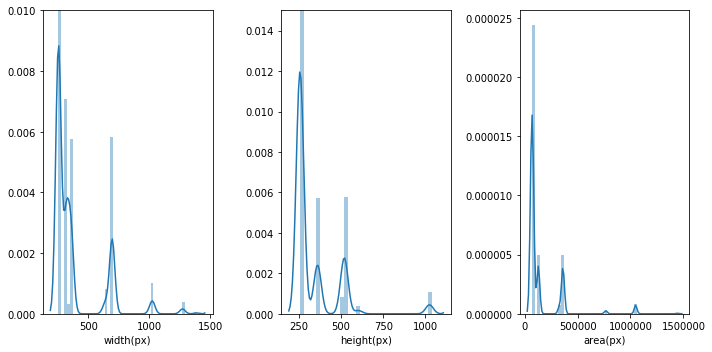

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
width_plt = sns.distplot(df_img['width'].values, ax=ax[0])
width_plt.set(xlabel='width(px)')
width_plt.set(ylim=(0, 0.01))
height_plt = sns.distplot(df_img['height'].values, ax=ax[1])
height_plt.set(xlabel='height(px)')
height_plt.set(ylim=(0,0.015))
area_plt = sns.distplot(df_img['area'].values)
area_plt.set(xlabel='area(px)')
fig.show()
plt.tight_layout()

### 各画像に含まれる核の数の分布

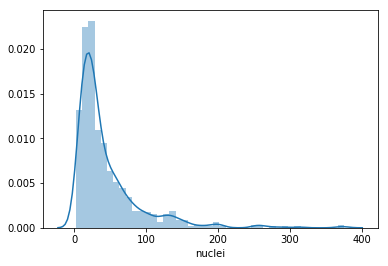

In [46]:
sns.distplot(df_img['nuclei'].values)
plt.xlabel('nuclei')
plt.show()

141


/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


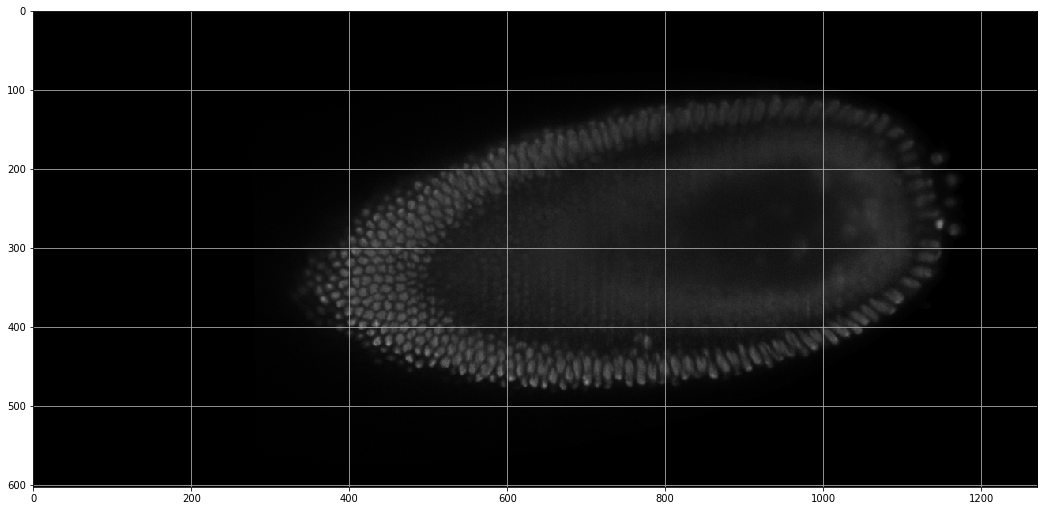

In [47]:
plt.figure(figsize=(18,18))
much_nuclei = df_img['nuclei'].argmax()
print(much_nuclei)
plt.grid(None)
plt.imshow(imgs[much_nuclei])

### 画像処理の基本  


In [48]:
import pathlib
import imageio
import numpy as np

training_paths = pathlib.Path('input/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[16]
im = imageio.imread(str(im_path))

### グレースケールに変換

In [49]:
print('Original image shape: {}'.format(im.shape))
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (256, 256, 4)
New image shape: (256, 256)


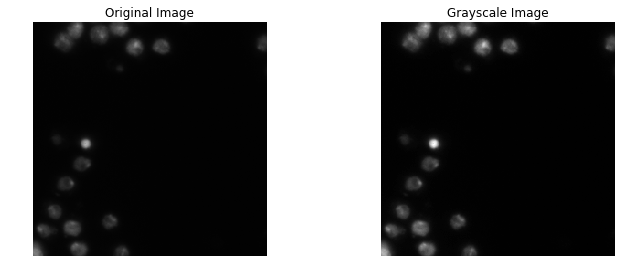

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

### 背景削除

In [51]:
from skimage.filters import threshold_otsu
#Otsu法による閾値算出
thresh_val = threshold_otsu(im_gray)
#その閾値で０、１の２値化
mask = np.where(im_gray > thresh_val, 1, 0)
#ピクセル数がより多い方のグループが背景。
#核の方を１に統一したいので１が多い場合は１、０を逆転させる
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

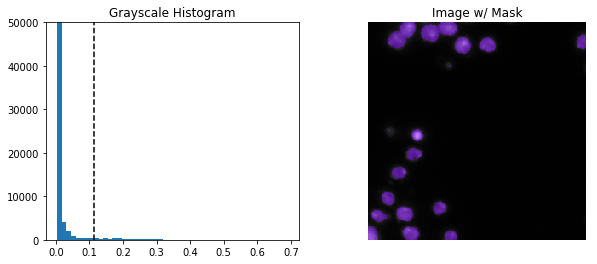

In [52]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
#グレースケール画像の最大最小間を５０に分割し、どの範囲に何ピクセル該当するかをヒストグラムで表示
plt.hist(im_pixels,bins=50)
# 閾値、つまり、核と背景の境界を可視化
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
#０の箇所をnanにする
mask_for_display = np.where(mask, mask, np.nan)
#一旦全てのピクセルをグレーにする
plt.imshow(im_gray, cmap='gray')
#核の部分だけを色付けする
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

In [53]:
# 上下左右に連続して存在する０以外の数字を１集団として順に番号をつけていく
from scipy import ndimage
labels, nlabels = ndimage.label(mask)
label_arrays = []
#各ラベル(番号)と一致するピクセルだけを１にしたものをappendする
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)
print('There are {} separate components / objects detected.'.format(nlabels))

There are 18 separate components / objects detected.


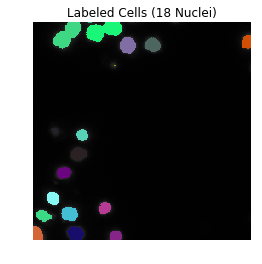

In [54]:
from matplotlib.colors import ListedColormap
#RGB値を乱数で異なる値にしたものを２５６色用意する
rand_cmap = ListedColormap(np.random.rand(256,3))
#背景(０)のピクセルの値をnanにする
labels_for_display = np.where(labels >0, labels, np.nan)
#一旦全ピクセルをgrayにする
plt.imshow(im_gray, cmap='gray')
#それぞれの核に色をつけて表示する
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

In [55]:
# セルのサイズが小さいラベルは０に戻す
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]

    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# 再度ラベルづけをする
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 1 is too small! Setting to 0.
Label 6 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
There are now 15 separate components / objects detected.


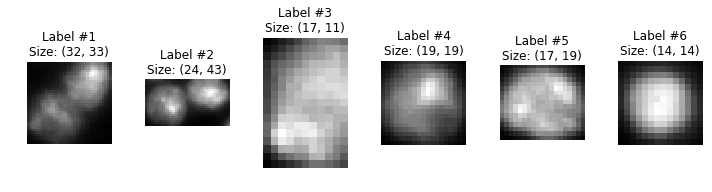

In [56]:
# 各ラベルの領域を切り出して表示する
fig, axes = plt.subplots(1,6, figsize=(10,6))
for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

In [57]:
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
#上下左右に数値がある要素を中心と見なしてその上下左右のみを残し斜めの位置の要素は消去する
#それを８回繰り返して分離する
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

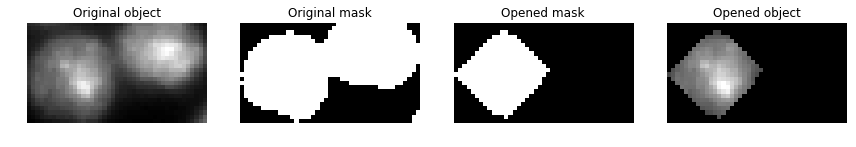

In [58]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [59]:
from skimage import morphology as mor
from skimage.morphology import disk
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

In [92]:
selem = disk(3)
selem

array([[0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=uint8)

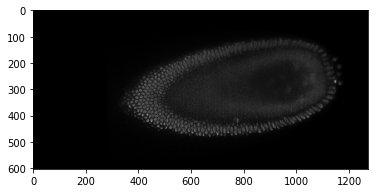

In [88]:
plt.imshow(imgs[much_nuclei])

## dailation

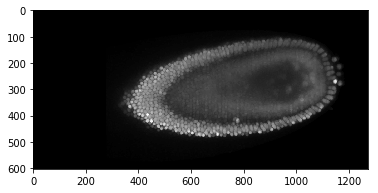

In [93]:
dailated = mor.dilation(rgb2gray(orig_phantom),selem=selem)
plt.imshow(dailated,cmap=plt.cm.gray)

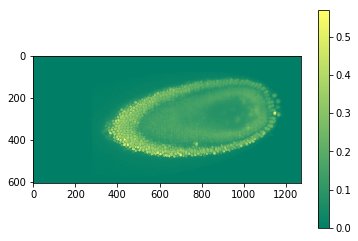

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
x = np.random.random((100, 100))
plt.imshow(dailated, cmap="summer")
plt.colorbar()

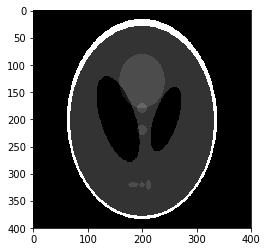

In [96]:
import os
import matplotlib.pyplot as plt
from skimage.data import data_dir
from skimage.util import img_as_ubyte
from skimage import io

orig_phantom = img_as_ubyte(io.imread(os.path.join(data_dir, "phantom.png"),
                                      as_gray=True))
fig, ax = plt.subplots()
ax.imshow(orig_phantom, cmap=plt.cm.gray)

## erosion

In [97]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

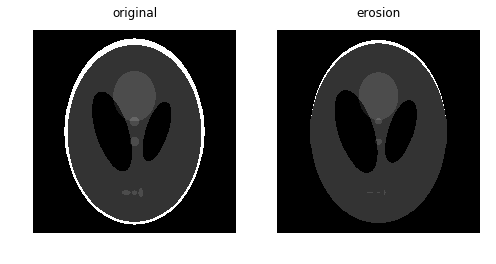

In [99]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

selem = disk(3)
eroded = erosion(rgb2gray(orig_phantom), selem)
plot_comparison(orig_phantom, eroded, 'erosion')

In [103]:
import cv2
# 3次元配列（高さ x 幅 x 色数）に変換して取得
# 0：グレースケール、1：カラー
sample_img = cv2.imread("sample/sample.png", 1)

### 平滑化（平均化フィルタ） 


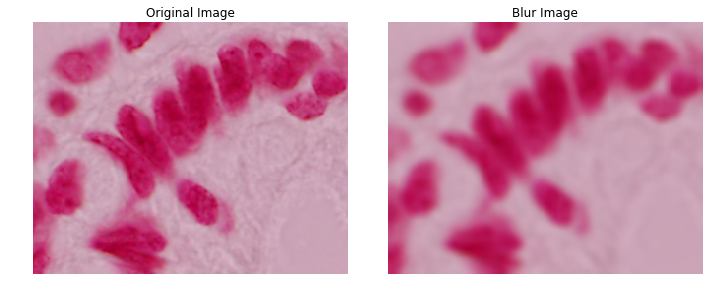

In [104]:
#10×10ピクセルの平均化フィルタをかけ、画像を滑らかにする。
average_square = (10,10)
blur_img = cv2.blur(sample_img, average_square)
cv2.imwrite('sample/blur_img.png', blur_img)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(sample_img)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(blur_img)
plt.axis('off')
plt.title('Blur Image')

plt.tight_layout()
plt.show()

### ノイズ（ガウシアンノイズ）


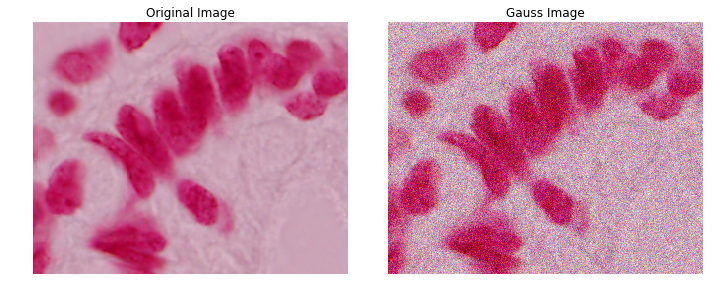

In [105]:
#各ピクセルにガウス分布に基づく値を足して、ノイズを付加
row,col,ch= sample_img.shape
mean = 0
sigma = 30
gauss = np.random.normal(mean,sigma,(row,col,ch))
gauss = gauss.reshape(row,col,ch)
gauss_img = sample_img + gauss
cv2.imwrite('sample/gauss_img.png', gauss_img)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(sample_img)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
ggg = cv2.imread("sample/gauss_img.png", 1)
plt.imshow(ggg)
plt.axis('off')
plt.title('Gauss Image')

plt.tight_layout()
plt.show()

### 水平・垂直反転

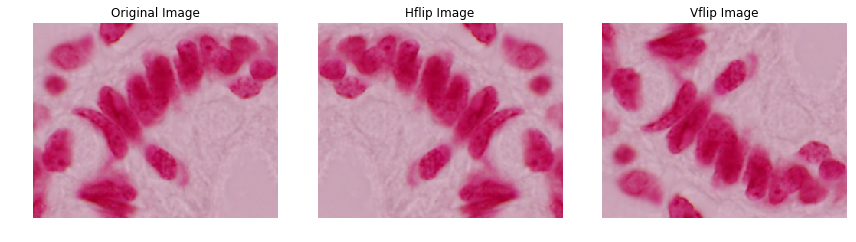

In [106]:
# 水平方向に反転
hflip_img = cv2.flip(sample_img, 1)
cv2.imwrite('sample/hflip_img.png', hflip_img)
# 垂直方向に反転
vflip_img = cv2.flip(sample_img, 0)
cv2.imwrite('sample/vflip_img.png', vflip_img)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))

plt.subplot(1,3,1)
plt.imshow(sample_img)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(hflip_img)
plt.axis('off')
plt.title('Hflip Image')

plt.subplot(1,3,3)
plt.imshow(vflip_img)
plt.axis('off')
plt.title('Vflip Image')

plt.tight_layout()
plt.show()

## U-Net論文のまとめ  




 
 
 

#### ・どんなもの？  

・生医学画像のセグメンテーションを全結合層なしのCNNのみで行う  
・ネットワークがUの字型をしており、ネットワークの前半の複数の層の出力を後半で利用している  
・ネットワークの前半でコンボリューション＋プーリングを行い、後半でコンボリューション＋アップサンプリングを行う   
・セグメンテーションコンテストのデータにおいて、従来手法を上回る結果を出している

#### ・先行研究と比べてどこがすごい？ 

・アノテーションされた画像が少ない状況でも先行研究よりも高い精度を出せる  
・異なる複数のタスクに対して高い精度を出せる（ニューロンのセグメンテーションと細胞のセグメンテーション）  
・タスク実行時の計算量が少なくて済む（512×512ピクセルの画像で１秒未満）

 #### ・技術や手法のキモはどこ？  

・ネットワークの後半のコンボリューション層において、前半のコンボリューション層の出力を利用することで  
　各特徴の位置情報を得られるようにしている  
・後半の層でフィルタの種類を多くしてコンテキスト情報を高解像度の層へ伝えることができるようにしている   
・入力画像の端に、その領域を鏡に映して反転させたような画像を付け足してコンテキスト情報を補足している 

#### ・どうやって有効だと検証した？ 

・EM segmentation challengeのデータにおいてWarping Errorが、それまでの１位の値よりも小さくなった  
・ISBI cell tracking challengeのデータにおいてベストスコアを出した(2015年時点)

#### ・議論はある？ 

ない

#### ・次に読むべき論文は？ 

複数のレイヤーからの特徴情報を利用する手法  
Hariharan, B., Arbelez, P., Girshick, R., Malik, J.: Hypercolumns for object seg- mentation and fine-grained localization (2014),arXiv:1411.5752 [cs.CV]

## U-Net実装

In [107]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [119]:
#訓練用画像データおよび正解マスクデータの読み込みとリサイズ
def train_preprocess(IMG_WIDTH=128, IMG_HEIGHT=128, IMG_CHANNELS=3, TRAIN_PATH = 'input/stage1_train/'):
    # Get train IDs
    train_ids = next(os.walk(TRAIN_PATH))[1]  

    # Get and resize train images and masks
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
       
    #パス合成
        path = TRAIN_PATH + id_
        #画像読み込み
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        #画像リサイズ
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        # 正解マスク
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            # マスク読み込み
            mask_ = imread(path + '/masks/' + mask_file)
            # リサイズ　＋　次元拡張
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
            Y_train[n] = mask
    return X_train, Y_train


def test_preprocess(IMG_WIDTH=128, IMG_HEIGHT=128, IMG_CHANNELS=3, TEST_PATH = 'input/stage1_test/'):    
    # Get and resize test images
    test_ids = next(os.walk(TEST_PATH))[1]
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('Getting and resizing test images ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
    return X_test


X_train, Y_train = train_preprocess()

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:00<00:00, 11.04it/s]


### mean IoU

In [110]:
def mean_iou(y_true, y_pred):
    prec = []
    #閾値を0.5 - 1.0 の間を0.０５刻みで変化させる
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        # ０、１の２クラス各々でのIOUを出して平均する(weight指定なし：均等に扱う)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            # backendのmeanメソッドを適用できるようにscoreをテンソル化
            score = tf.identity(score)
        prec.append(score)
        #各スコアテンソルを行方向に連結してから平均する
    return K.mean(K.stack(prec), axis=0)

### クラス化

In [130]:
class Unet():
    
    def __init__(self, input_d1=128, input_d2=128, input_d3=3, optimizer='adam', \
                 loss_func='binary_crossentropy',x='None',y='None',
                 metrics=mean_iou, test_ratio=0.2, validation_split=0.1, batch_size=8,
                 epochs=2, patience=5, weight_file_name='None', save_best_only=True, fit_verbose=1,
                 eval_verbose=0):
        
        #net_builder
        self.input_d1 = input_d1
        self.input_d2 = input_d2
        self.input_d3 = input_d3
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.metrics = metrics
        #create_test_from_train
        self.X_train = x
        self.Y_train = y
        self.test_ratio = test_ratio
        #model_fit
        self.validation_split = validation_split
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.weight_file_name = weight_file_name
        self.save_best_only = save_best_only
        self.fit_verbose = fit_verbose
        #model_eval
        self.eval_verbose = eval_verbose
        
        global x_train
        global y_train
        global x_test
        global y_test
        self.X_train = x_train
        self.Y_train = y_train
        self.X_test = x_test
        self.Y_test = y_test
     

    def net_builder(self):
        
        inputs = Input((self.input_d1, self.input_d2, self.input_d3))
        s = Lambda(lambda x: x / 255) (inputs)

        c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
        c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
        p1 = MaxPooling2D((2, 2)) (c1)

        c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
        c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
        p2 = MaxPooling2D((2, 2)) (c2)

        c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
        c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
        p3 = MaxPooling2D((2, 2)) (c3)

        c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
        c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

        c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
        c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

        u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
        c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

        u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
        c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

        u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
        c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

        u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
        c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

        outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

        self.model = Model(inputs=[inputs], outputs=[outputs])
        self.model.compile(self.optimizer, self.loss_func, metrics=[self.metrics])
        #self.model.summary()
        return self.model
    
    
    # トレインデータの一部をテストデータとして使う場合に使用する
    #データ数がshapeの０次元にあることを前提としている
    def create_test_from_train(self):
        data_range = int(self.X_train.shape[0]*(1-self.test_ratio))
        self.X_test =  np.array(self.X_train[data_range:,:,:,:])  
        self.Y_test =  np.array(self.Y_train[data_range:,:,:,:])
        self.X_train = np.array(self.X_train[:data_range,:,:,:])
        self.Y_train = np.array(self.Y_train[:data_range,:,:,:])
        return self.X_train, self.Y_train, self.X_test, self.Y_test
    
    
    def model_fit(self):
        earlystopper = EarlyStopping(patience=self.patience, verbose=self.fit_verbose)
        # modelを保存するかどうかで分ける
        if self.weight_file_name=='None':
            callbacks=[earlystopper]
        else:
            checkpointer = ModelCheckpoint(filepath=self.weight_file_name, verbose=self.verbose,\
                                           save_best_only=self.save_best_only)
            callbacks=[earlystopper, checkpointer]
        self.fit_results = self.model.fit(x=self.X_train, y=self.Y_train, epochs=self.epochs,\
                                          batch_size=self.batch_size, verbose=self.fit_verbose,\
                                          callbacks=callbacks, validation_split=self.validation_split) 
        return self.fit_results
    
    
    def model_eval(self):
        self.eval_result = self.model.evaluate(x=self.X_test, y=self.Y_test, batch_size=self.batch_size,\
                                               verbose=self.eval_verbose)
        return self.eval_result
    
    def predict(self, data):
        return self.model.predict(data)

#### テストデータ作成 (テスト用に２割分離しておく)

In [114]:
def test_date(X_train, Y_train, test_ratio):
    data_range = int(X_train.shape[0]*(1-test_ratio))
    X_test =  np.array(X_train[data_range:,:,:,:])  
    Y_test =  np.array(Y_train[data_range:,:,:,:])
    X_train = np.array(X_train[:data_range,:,:,:])
    Y_train = np.array(Y_train[:data_range,:,:,:])
    return X_train, Y_train, X_test, Y_test
x_train, y_train, x_test, y_test = test_date(X_train, Y_train, test_ratio=0.2)

In [131]:
def unet_exe(validation_split=0.1, batch_size=8, epochs=30, optimizer='adam',fit_verbose=1):
    unet=Unet(validation_split=validation_split, batch_size=batch_size, epochs=epochs, optimizer=optimizer,\
              fit_verbose=fit_verbose)
    unet.net_builder()
    unet.model_fit()
    return unet
trained_unet = unet_exe()

Train on 482 samples, validate on 54 samples
Epoch 1/30
482/482 [==============================] - 28s 58ms/step - loss: 0.4991 - mean_iou: 0.4181 - val_loss: 0.4099 - val_mean_iou: 0.4252
Epoch 2/30
482/482 [==============================] - 25s 53ms/step - loss: 0.3017 - mean_iou: 0.4251 - val_loss: 0.2495 - val_mean_iou: 0.4262
Epoch 3/30
482/482 [==============================] - 27s 56ms/step - loss: 0.1990 - mean_iou: 0.4373 - val_loss: 0.1672 - val_mean_iou: 0.4645
Epoch 4/30
482/482 [==============================] - 26s 54ms/step - loss: 0.1490 - mean_iou: 0.4974 - val_loss: 0.1503 - val_mean_iou: 0.5271
Epoch 5/30
482/482 [==============================] - 26s 53ms/step - loss: 0.1160 - mean_iou: 0.5523 - val_loss: 0.1417 - val_mean_iou: 0.5774
Epoch 6/30
482/482 [==============================] - 27s 56ms/step - loss: 0.1100 - mean_iou: 0.5970 - val_loss: 0.1501 - val_mean_iou: 0.6140
Epoch 7/30
482/482 [==============================] - 28s 58ms/step - loss: 0.1043 - mean_i

#### 結果を視覚的に確認

In [132]:
predx = trained_unet.predict(x_test)
predx_t = (predx > 0.5).astype(np.uint8)

/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


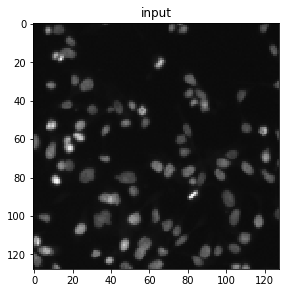

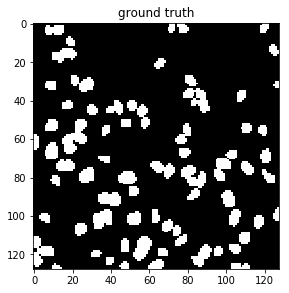

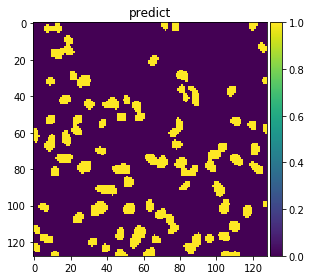

In [170]:
ix = random.randint(0, x_test.shape[0])
imshow(x_test[ix])
plt.title("input")
plt.show()
imshow(np.squeeze(y_test[ix]))
plt.title("ground truth")
plt.show()

plt.title("predict")
imshow(np.squeeze(predx_t[ix]))
plt.show()

In [120]:
X_test = test_preprocess()

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 98.54it/s]


In [142]:
preds = trained_unet.predict(X_test)
preds_t = (preds > 0.5).astype(np.uint8)

/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


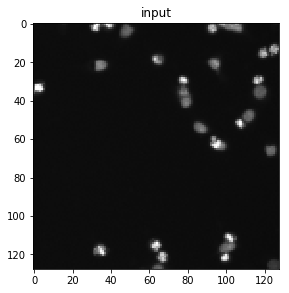

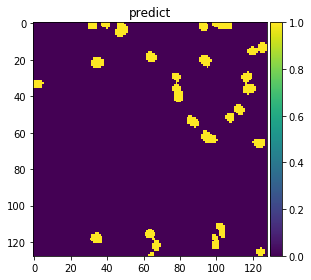

In [172]:
ix = random.randint(0, X_test.shape[0])
imshow(X_test[ix])
plt.title("input")
plt.show()
plt.title("predict")
imshow(np.squeeze(preds_t[ix]))
plt.show()

#### 評価用関数（クラスインスタンス作成〜評価まで）

In [31]:
def unet_opt(validation_split=0.1, batch_size=8, epochs=30, optimizer='adam',fit_verbose=1):
    unet=Unet(validation_split=validation_split, batch_size=batch_size, epochs=epochs, optimizer=optimizer,\
              fit_verbose=fit_verbose)
    unet.net_builder()
    unet.model_fit()
    unet_result = unet.model_eval()
    return unet_result

#### デフォルトパラメータでの実行（optimizer='adam'）

In [32]:
result = unet_opt()
print("loss:{0}, accuracy:{1}".format(result[0], result[1]))

Train on 482 samples, validate on 54 samples
Epoch 1/30
482/482 [==============================] - 42s 88ms/step - loss: 0.5554 - mean_iou: 0.4139 - val_loss: 0.4739 - val_mean_iou: 0.4259
Epoch 2/30
482/482 [==============================] - 3s 6ms/step - loss: 0.3778 - mean_iou: 0.4250 - val_loss: 0.3889 - val_mean_iou: 0.4247
Epoch 3/30
482/482 [==============================] - 3s 6ms/step - loss: 0.3050 - mean_iou: 0.4243 - val_loss: 0.3116 - val_mean_iou: 0.4245
Epoch 4/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2449 - mean_iou: 0.4312 - val_loss: 0.2743 - val_mean_iou: 0.4491
Epoch 5/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1915 - mean_iou: 0.4705 - val_loss: 0.2238 - val_mean_iou: 0.4917
Epoch 6/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1773 - mean_iou: 0.5055 - val_loss: 0.1950 - val_mean_iou: 0.5216
Epoch 7/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1445 - mean_iou: 0.5348 -

#### デフォルトパラメータでの実行（optimizer='adadelta'）

In [33]:
from keras import optimizers
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
result1 = unet_opt(optimizer=adadelta)
print("loss:{0}, accuracy:{1}".format(result1[0], result1[1]))

Train on 482 samples, validate on 54 samples
Epoch 1/30
482/482 [==============================] - 6s 12ms/step - loss: 0.4407 - mean_iou: 0.4171 - val_loss: 0.3573 - val_mean_iou: 0.4244
Epoch 2/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2816 - mean_iou: 0.4254 - val_loss: 0.2817 - val_mean_iou: 0.4283
Epoch 3/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2110 - mean_iou: 0.4352 - val_loss: 0.2576 - val_mean_iou: 0.4472
Epoch 4/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1732 - mean_iou: 0.4661 - val_loss: 0.2144 - val_mean_iou: 0.4879
Epoch 5/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1422 - mean_iou: 0.5102 - val_loss: 0.1665 - val_mean_iou: 0.5315
Epoch 6/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1329 - mean_iou: 0.5496 - val_loss: 0.2006 - val_mean_iou: 0.5652
Epoch 7/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1270 - mean_iou: 0.5776 - 

### U-Net ハイパーパラメータチューニング（Beisian optimization）

In [35]:
import GPyOpt

#### 探索パラメータ引き渡し用関数

In [38]:
def f(x):
    print("*"*50)
    print("lr, rho, epsilon, decay")
    print(x)
    adadelta = optimizers.Adadelta(lr=float(x[:,0]), rho=float(x[:,1]), epsilon=float(x[:,2]),\
                                   decay=float(x[:,3]))
    unet_result = unet_opt(optimizer=adadelta)
    print("loss:{0}, accuracy:{1}".format(unet_result[0], unet_result[1]))
    # 最小化対象はloss
    return unet_result[0]

#### 探索パラメータ

In [37]:
para_range = [{'name': 'lr',       'type': 'continuous',  'domain': (0.8, 1.2)},
              {'name': 'rho',      'type': 'continuous',  'domain': (0.9, 0.99)},
              {'name': 'epsilon',  'type': 'continuous',  'domain': (1e-10, 1e-7)},
              {'name': 'decay',    'type': 'continuous',  'domain': (1e-10, 0.01)}]

#### 探索実施

In [39]:
unet_bays = GPyOpt.methods.BayesianOptimization(f=f, domain=para_range)
unet_bays

**************************************************
lr, rho, epsilon, decay
[[1.03524515e+00 9.72405764e-01 2.88810061e-08 1.41773293e-04]]
Train on 482 samples, validate on 54 samples
Epoch 1/30
482/482 [==============================] - 6s 13ms/step - loss: 0.4461 - mean_iou: 0.4165 - val_loss: 0.5143 - val_mean_iou: 0.4241
Epoch 2/30
482/482 [==============================] - 3s 6ms/step - loss: 0.3006 - mean_iou: 0.4233 - val_loss: 0.3010 - val_mean_iou: 0.4238
Epoch 3/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2316 - mean_iou: 0.4244 - val_loss: 0.2751 - val_mean_iou: 0.4258
Epoch 4/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2129 - mean_iou: 0.4300 - val_loss: 0.2868 - val_mean_iou: 0.4372
Epoch 5/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1876 - mean_iou: 0.4471 - val_loss: 0.2331 - val_mean_iou: 0.4594
Epoch 6/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1665 - mean_iou: 0.4720 - val

Epoch 20/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1119 - mean_iou: 0.6549 - val_loss: 0.1374 - val_mean_iou: 0.6580
Epoch 21/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1109 - mean_iou: 0.6608 - val_loss: 0.1371 - val_mean_iou: 0.6638
Epoch 22/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1086 - mean_iou: 0.6667 - val_loss: 0.1560 - val_mean_iou: 0.6693
Epoch 23/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1088 - mean_iou: 0.6720 - val_loss: 0.1343 - val_mean_iou: 0.6744
Epoch 24/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1077 - mean_iou: 0.6765 - val_loss: 0.1316 - val_mean_iou: 0.6789
Epoch 25/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1068 - mean_iou: 0.6811 - val_loss: 0.1412 - val_mean_iou: 0.6832
Epoch 26/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1067 - mean_iou: 0.6853 - val_loss: 0.1310 - val_mean_iou: 0.6873

In [40]:
unet_bays.run_optimization(max_iter=10)

**************************************************
lr, rho, epsilon, decay
[[8.00854785e-01 9.83771020e-01 2.18036381e-08 3.97433524e-03]]
Train on 482 samples, validate on 54 samples
Epoch 1/30
482/482 [==============================] - 8s 17ms/step - loss: 0.4704 - mean_iou: 0.4206 - val_loss: 0.4496 - val_mean_iou: 0.4241
Epoch 2/30
482/482 [==============================] - 3s 6ms/step - loss: 0.3226 - mean_iou: 0.4241 - val_loss: 0.3806 - val_mean_iou: 0.4238
Epoch 3/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2655 - mean_iou: 0.4237 - val_loss: 0.5851 - val_mean_iou: 0.4241
Epoch 4/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2294 - mean_iou: 0.4276 - val_loss: 0.2736 - val_mean_iou: 0.4353
Epoch 5/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1863 - mean_iou: 0.4497 - val_loss: 0.2141 - val_mean_iou: 0.4680
Epoch 6/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1521 - mean_iou: 0.4862 - val

482/482 [==============================] - 3s 6ms/step - loss: 0.2066 - mean_iou: 0.5049 - val_loss: 0.3302 - val_mean_iou: 0.5194
Epoch 5/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1804 - mean_iou: 0.5326 - val_loss: 0.2194 - val_mean_iou: 0.5462
Epoch 6/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1673 - mean_iou: 0.5578 - val_loss: 0.1856 - val_mean_iou: 0.5683
Epoch 7/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1585 - mean_iou: 0.5776 - val_loss: 0.1964 - val_mean_iou: 0.5864
Epoch 8/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1401 - mean_iou: 0.5953 - val_loss: 0.1716 - val_mean_iou: 0.6036
Epoch 9/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1334 - mean_iou: 0.6107 - val_loss: 0.1662 - val_mean_iou: 0.6182
Epoch 10/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1282 - mean_iou: 0.6248 - val_loss: 0.1639 - val_mean_iou: 0.6310
Epoch 11/30
482/

Epoch 00029: early stopping
loss:0.09278022920462622, accuracy:0.7451828255582211
**************************************************
lr, rho, epsilon, decay
[[1.19947635e+00 9.77650797e-01 7.87443020e-08 1.70253163e-03]]
Train on 482 samples, validate on 54 samples
Epoch 1/30
482/482 [==============================] - 10s 22ms/step - loss: 0.4399 - mean_iou: 0.4169 - val_loss: 0.4647 - val_mean_iou: 0.4280
Epoch 2/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2605 - mean_iou: 0.4350 - val_loss: 0.3719 - val_mean_iou: 0.4495
Epoch 3/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2275 - mean_iou: 0.4658 - val_loss: 0.5877 - val_mean_iou: 0.4809
Epoch 4/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1820 - mean_iou: 0.4951 - val_loss: 0.1760 - val_mean_iou: 0.5153
Epoch 5/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1318 - mean_iou: 0.5376 - val_loss: 0.3823 - val_mean_iou: 0.5563
Epoch 6/30
482/482 [==

Epoch 25/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1081 - mean_iou: 0.5965 - val_loss: 0.1296 - val_mean_iou: 0.6002
Epoch 26/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1059 - mean_iou: 0.6039 - val_loss: 0.1333 - val_mean_iou: 0.6072
Epoch 27/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1051 - mean_iou: 0.6103 - val_loss: 0.1335 - val_mean_iou: 0.6136
Epoch 28/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1041 - mean_iou: 0.6167 - val_loss: 0.1262 - val_mean_iou: 0.6198
Epoch 29/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1025 - mean_iou: 0.6227 - val_loss: 0.1404 - val_mean_iou: 0.6256
Epoch 30/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1029 - mean_iou: 0.6284 - val_loss: 0.1243 - val_mean_iou: 0.6311
loss:0.10382948159726697, accuracy:0.6320043250695982
**************************************************
lr, rho, epsilon, decay
[[1.19976102e

482/482 [==============================] - 3s 6ms/step - loss: 0.0987 - mean_iou: 0.6940 - val_loss: 0.1224 - val_mean_iou: 0.6969
Epoch 20/30
482/482 [==============================] - 3s 6ms/step - loss: 0.0986 - mean_iou: 0.6996 - val_loss: 0.1220 - val_mean_iou: 0.7023
Epoch 21/30
482/482 [==============================] - 3s 6ms/step - loss: 0.0971 - mean_iou: 0.7048 - val_loss: 0.1208 - val_mean_iou: 0.7072
Epoch 22/30
482/482 [==============================] - 3s 6ms/step - loss: 0.0969 - mean_iou: 0.7096 - val_loss: 0.1201 - val_mean_iou: 0.7118
Epoch 23/30
482/482 [==============================] - 3s 6ms/step - loss: 0.0959 - mean_iou: 0.7139 - val_loss: 0.1199 - val_mean_iou: 0.7161
Epoch 24/30
482/482 [==============================] - 3s 6ms/step - loss: 0.0958 - mean_iou: 0.7181 - val_loss: 0.1220 - val_mean_iou: 0.7201
Epoch 25/30
482/482 [==============================] - 3s 6ms/step - loss: 0.0947 - mean_iou: 0.7220 - val_loss: 0.1193 - val_mean_iou: 0.7239
Epoch 26/30

#### 結果

In [41]:
print("lr:{0}, rho:{1}, epsilon:{2}, decay:{3}".format(unet_bays.x_opt[0],unet_bays.x_opt[1],\
                                                                unet_bays.x_opt[2], unet_bays.x_opt[3]))
print("loss with these parameters : ",unet_bays.fx_opt)

lr:1.1979511245097498, rho:0.9822207119890403, epsilon:7.778662830406928e-08, decay:0.007356574135112844
loss with these parameters :  0.08459313202704956


In [42]:
adadelta = optimizers.Adadelta(lr=unet_bays.x_opt[0], rho=unet_bays.x_opt[1], epsilon=unet_bays.x_opt[2], decay=unet_bays.x_opt[3])
result1 = unet_opt(optimizer=adadelta)
print("loss:{0}, accuracy:{1}".format(result1[0], result1[1]))

Train on 482 samples, validate on 54 samples
Epoch 1/30
482/482 [==============================] - 12s 25ms/step - loss: 0.4515 - mean_iou: 0.4186 - val_loss: 0.3985 - val_mean_iou: 0.4241
Epoch 2/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2860 - mean_iou: 0.4250 - val_loss: 0.3404 - val_mean_iou: 0.4289
Epoch 3/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2429 - mean_iou: 0.4449 - val_loss: 0.9602 - val_mean_iou: 0.4623
Epoch 4/30
482/482 [==============================] - 3s 6ms/step - loss: 0.2347 - mean_iou: 0.4701 - val_loss: 0.2695 - val_mean_iou: 0.4837
Epoch 5/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1872 - mean_iou: 0.4991 - val_loss: 0.2262 - val_mean_iou: 0.5125
Epoch 6/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1691 - mean_iou: 0.5248 - val_loss: 0.4889 - val_mean_iou: 0.5367
Epoch 7/30
482/482 [==============================] - 3s 6ms/step - loss: 0.1536 - mean_iou: 0.5477 -

### Mask-RCNN  論文まとめ


#### ・どんなもの？

・画像内の物体を効率的に検出  
・各物体に対して高品質のセグメンテーションマスクを生成  
・人体ポーズを推定（キーポイントの検出）

#### ・先行研究と比べてどこがすごい？

・物体検出結果として得られた領域についてのみセグメンテーションするので、全ピクセルについての  
　クラス検出よりも効率的  
・ネットワーク入出力での物体領域のピクセルのズレを解消することで、精度の高いセグメンテーションを実現

#### ・技術や手法のキモはどこ？

・Faster R-CNNに追加拡張  
　バウンディングボックス認識のために既存のブランチと並行してオブジェクトマスクを予測し、    
　セグメント化するためのブランチ（Mask Branch）をFaster R-CNNに追加拡張  
・RoIPoolingからRoIAlign layerに改修  
　RPNで提案された領域をそのまま利用し、各セル内の4点の近傍4ピクセルから双線形補間(bilinear interpolation)を  
　用いて各点の値を算し、それら4点をプーリングで縮約することで、物体領域のピクセルのズレを解消

#### ・どうやって有効だと検証した？  

・先行研究であるFaster R-CNNと比較して高い精度を出している  
・RoIPoolingと比較してもRoIAlign layerが高い精度を出している

#### ・議論はある？  

なし

#### ・次に読むべき論文は？

・R-CNN  
・Fast R-CNN  
・Faster R-CNN